In [158]:
# General:
import sys
import tweepy           # To consume Twitter's API
import re
import math
import numpy as np
sc

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
# For plotting and visualization:
from IPython.display import display
import matplotlib.pyplot as plt
from pyspark.sql.types import *
from pyspark.sql import *
from pyspark.sql.functions import lit
from pyspark.sql import functions as func
from pyspark.sql.functions  import col
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import bround
from pyspark.sql import Row
from dateutil import parser
from pyspark.sql.types import *


In [3]:
# Consume:
CONSUMER_KEY    = ''
CONSUMER_SECRET = ''

# Access:
ACCESS_TOKEN  = ''
ACCESS_SECRET = ''

In [161]:

def twitter():
    # Authentication and access using keys:
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

    # Return API with authentication:
    api = tweepy.API(auth)
    return api

['BackToHogwarts', 'BackToHogwarts', 'FantasticBeasts', 'BackToHogwarts', 'BackToHogwarts', 'rt', 'follow', 'fback', 'wrzesniowefolllowspree', 'BackToHogwarts', 'BackToHogwarts', 'BackToHogwarts', 'FantasticBeasts', 'CrimesofGrindelwald', 'BackToHogwarts', 'BackToHogwarts', 'FantasticBeasts', 'BackToHogwarts', 'BackToHogwarts', 'CommonRoom', 'BacktoHogwarts', 'AnimaisFantasticos', 'BackToHogwarts', 'BackToHogwarts', 'BackToHogwarts', 'BackToHogwarts', 'BackToHogwarts', 'FantasticBeasts', 'BackToHogwarts', 'FantasticBeasts', 'BackToHogwarts', 'BackToHogwarts', 'FantasticBeasts', 'BackToHogwarts', 'backtohogwarts', 'rt', 'fav', 'BackToHogwarts', 'BackToSchool', 'BackToHogwarts', 'harrypotter', 'platform9and3quarters', 'BackToHogwarts', 'backtohogwarts', 'FantasticBeasts', 'BackToHogwarts', 'BackToHogwarts', 'BackToHogwarts', 'FantasticBeasts', 'FantasticBeasts', 'BackToHogwarts', 'BackToHogwarts', 'Platform9and3Quarters', 'KingsCross', 'BackToHogwarts', 'BackToHogwarts', 'FantasticBeasts

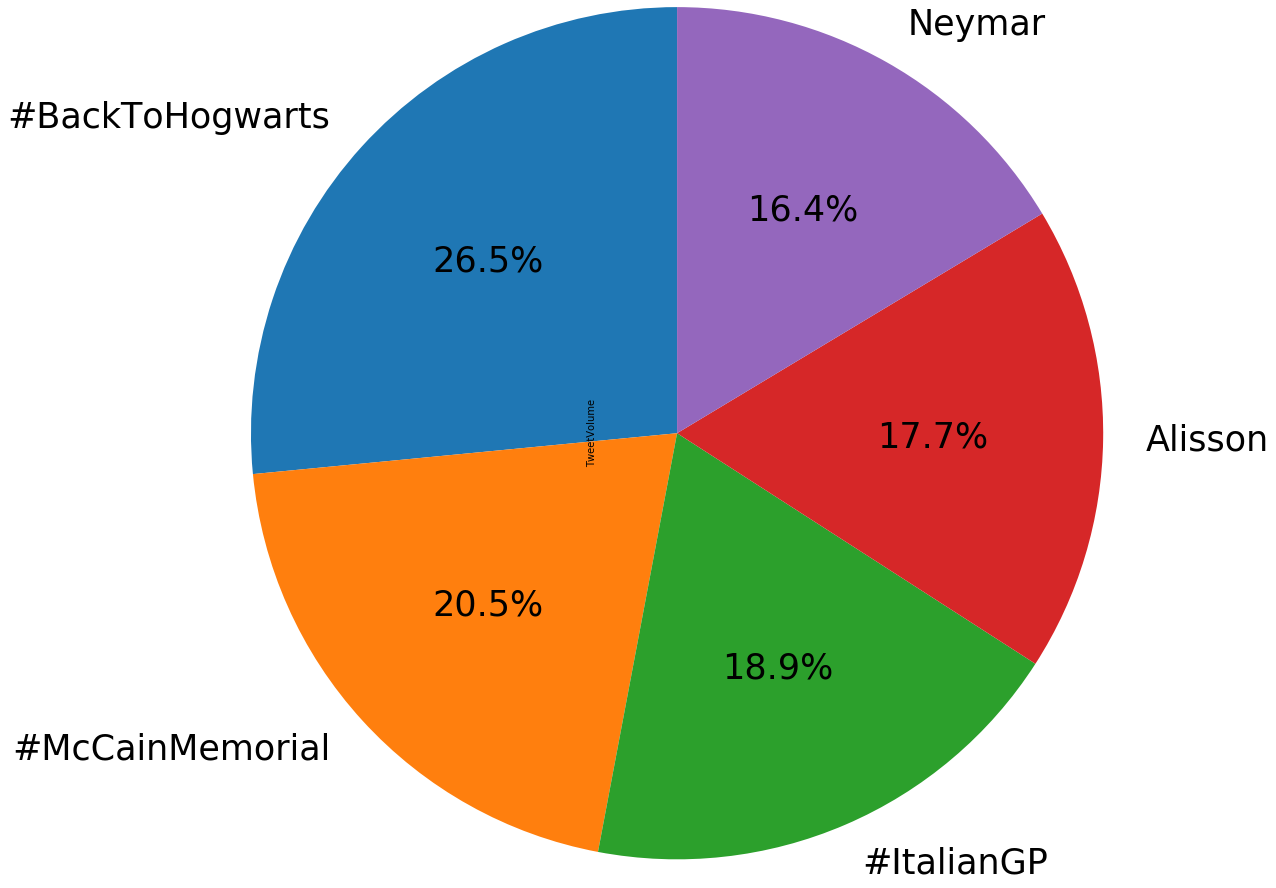

In [162]:
#Enter WOEID oF Location to know MOST POPULAR TWEETS in that location
api = twitter()
tweet_pop = []
place = api.trends_place(id = 44418) #Texas
for location in place:
    for trend in location["trends"]:
        tweet_pop.append(trend["name"])
        tweet_pop.append(trend["tweet_volume"])

# find top 5 popular tweet topic based on tweet volume        
pop_list_tweet = [tweet_pop[2*i:2*i+2] for i in range(0,math.ceil(len(tweet_pop)/2))]
pop_list_tweet = spark.createDataFrame(pop_list_tweet, ["Tweet", "TweetVolume"])
pop_list_tweet = pop_list_tweet.withColumn("Tweet", pop_list_tweet["Tweet"].cast(StringType())).withColumn("TweetVolume", pop_list_tweet["TweetVolume"].cast(IntegerType()))
pop_list_tweet = pop_list_tweet.sort(desc("TweetVolume")).limit(5)
popular = pop_list_tweet.select(col("Tweet")).limit(1).collect()
res={}
for i in popular:
    res.update(i.asDict())
mostPopular= res['Tweet']
plt.title("Most Popular Tweets  ",fontsize = 40)
pop=pop_list_tweet.toPandas()
ax1 = plt.subplot(121, aspect='equal')
pop.plot(kind='pie', y = 'TweetVolume', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=pop['Tweet'], legend = False, fontsize= 35, radius=7)


#search the most poplar tweet topic and retrieve tweets on it
tweets = api.search(q=mostPopular, count=1500)
lists = []
for tweet in tweets[:1500]:
    hashtags = tweet.entities.get('hashtags')
    for hashtag in hashtags:
            lists.append(hashtag['text'])
print(lists)

+--------------------+
|            Hashtags|
+--------------------+
|      BackToHogwarts|
|      BackToHogwarts|
|     FantasticBeasts|
|      BackToHogwarts|
|      BackToHogwarts|
|                  rt|
|              follow|
|               fback|
|wrzesniowefolllow...|
|      BackToHogwarts|
|      BackToHogwarts|
|      BackToHogwarts|
|     FantasticBeasts|
| CrimesofGrindelwald|
|      BackToHogwarts|
|      BackToHogwarts|
|     FantasticBeasts|
|      BackToHogwarts|
|      BackToHogwarts|
|          CommonRoom|
+--------------------+
only showing top 20 rows



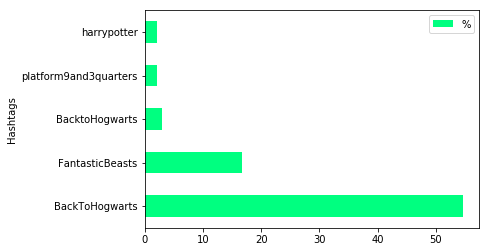

In [163]:
#get top popular hashtags used in tweets for the topic
rdd = sc.parallelize(lists)
new_row = Row("Hashtags")
df = rdd.map(new_row).toDF()
df.show()

#calculate percentages of the top hashtags
from pyspark.sql.types import StructType
total=df.count()
result=(df.groupBy('Hashtags').count()
    .withColumn('Total',func.lit(total))
    .withColumn('Percentage',(col('count')/col('Total') *100))
    .withColumn('%',bround('Percentage',2))
    .sort(desc('%'))
    .limit(5)
    )

#plot popular hashtags
pdf1=result.toPandas()
pdf1.plot(kind='barh',x='Hashtags',y='%',colormap='winter_r')

In [164]:
#Details about the tweets on popular topic (Tweet, Retweet, Likes, Creation Date)
list_tweet = []
for tweet in tweets:
    data = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', tweet.text).replace("\n","")
    list_tweet.append(data)
    list_tweet.append(tweet.retweet_count)
    list_tweet.append(tweet.favorite_count)
    list_tweet.append(str(parser.parse(str(tweet.created_at))))
list_tweet = [list_tweet[4*i:4*i+4] for i in range(0,math.ceil(len(list_tweet)/4))]
tweet_df = spark.createDataFrame(list_tweet, ["Tweet", "Retweet","Likes","Created_At"])
tweet_df = tweet_df.withColumn("Retweet", tweet_df["Retweet"].cast(IntegerType())).withColumn("Likes", tweet_df["Likes"].cast(IntegerType())).withColumn("Created_At", tweet_df["Created_At"].cast(DateType()))
tweet_df.show()

+--------------------+-------+-----+----------+
|               Tweet|Retweet|Likes|Created_At|
+--------------------+-------+-----+----------+
|RT @EiProfeta: Un...|   6644|    0|2018-09-01|
|RT @BeastsMovieUK...|    617|    0|2018-09-01|
|RT @potterish: Ch...|     44|    0|2018-09-01|
|RT @potterish: Ch...|     44|    0|2018-09-01|
|RT @wyszywana: ❗S...|      2|    0|2018-09-01|
|RT @pottermore: G...|   2160|    0|2018-09-01|
|RT @TeamStarKid: ...|    651|    0|2018-09-01|
|RT @tessanetting:...|     33|    0|2018-09-01|
|RT @HarryPotterFi...|   4018|    0|2018-09-01|
|RT @angelicsangst...|    735|    0|2018-09-01|
|RT @BeastsMovieUK...|   1461|    0|2018-09-01|
|RT @HarryLatino: ...|     29|    0|2018-09-01|
|Finalmente em cas...|      0|    0|2018-09-01|
|My #CommonRoom to...|      0|    0|2018-09-01|
|RT @potterish: O ...|    100|    0|2018-09-01|
|RT @FantasticBeas...|   2156|    0|2018-09-01|
|RT @pottermore: F...|   2049|    0|2018-09-01|
|RT @Neshema_: Lis...|     48|    0|2018

+--------------------+-------+
|               Tweet|Retweet|
+--------------------+-------+
|RT @EiProfeta: Un...|  46508|
|RT @HarryPotterFi...|  20090|
|RT @BeastsMovieUK...|  16479|
|RT @BeastsMovieUK...|  14616|
|RT @FantasticBeas...|   6468|
+--------------------+-------+



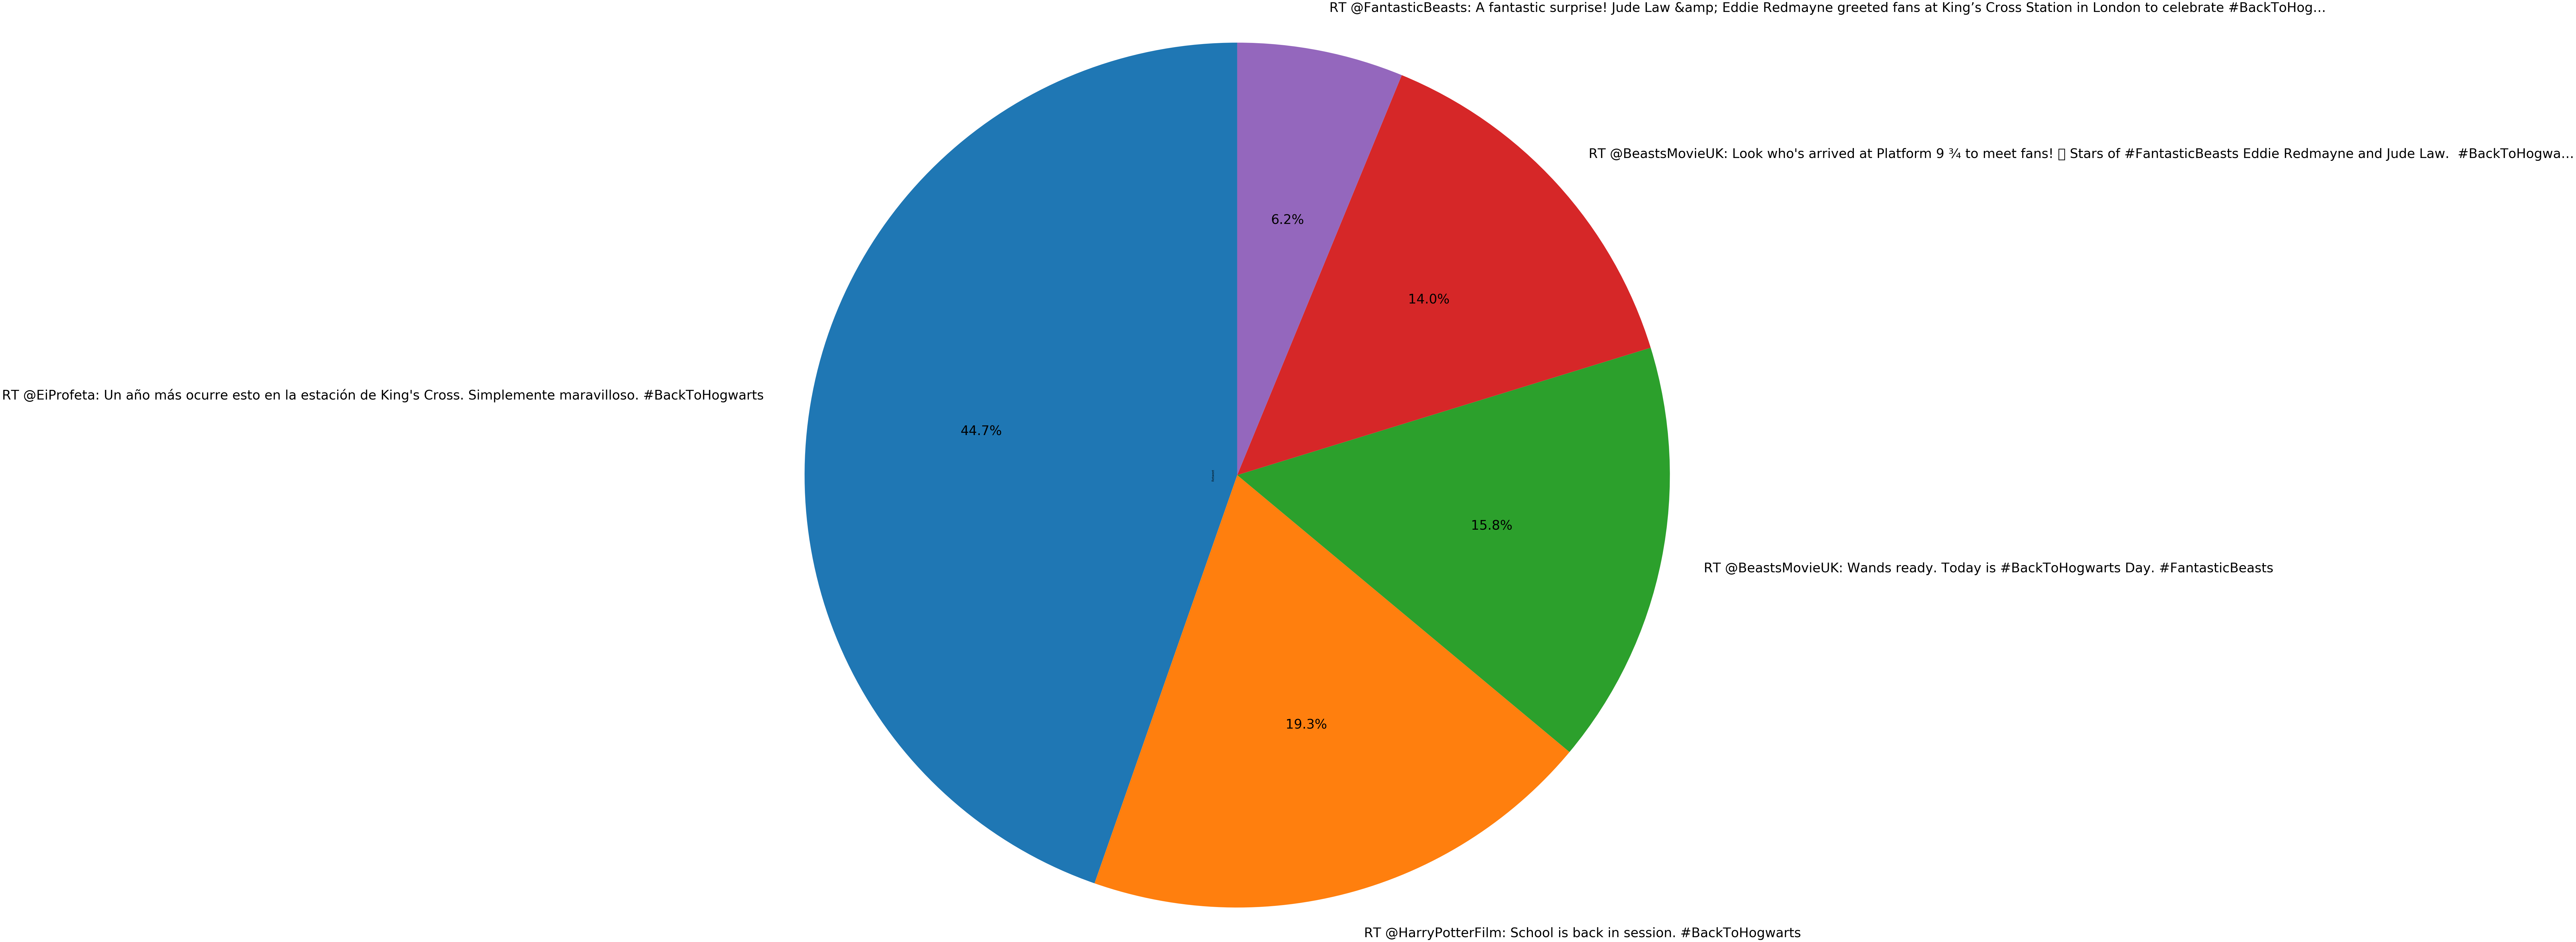

In [165]:
#retrieve top 5 most retweeted tweets
max_retweet = tweet_df.groupBy('Tweet').agg(func.sum("Retweet").alias('Retweet'))
max_retweet = max_retweet.sort(desc('Retweet')).limit(5)
max_retweet.show()
plt.title("Most Retweeted Tweets on " + mostPopular,fontsize = 40)
pdf2=max_retweet.toPandas()
ax1 = plt.subplot(121, aspect='equal')
pdf2.plot(kind='pie', y = 'Retweet', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=pdf2['Tweet'], legend = False, fontsize= 46, radius=25)


+--------------------+-----+
|               Tweet|Likes|
+--------------------+-----+
|A prof Grubbly-Pl...|   10|
|@ProfessorDum Olh...|    1|
|RT @BeastsMovieUK...|    0|
|RT @amanosetvale:...|    0|
|RT @pottermore: A...|    0|
+--------------------+-----+



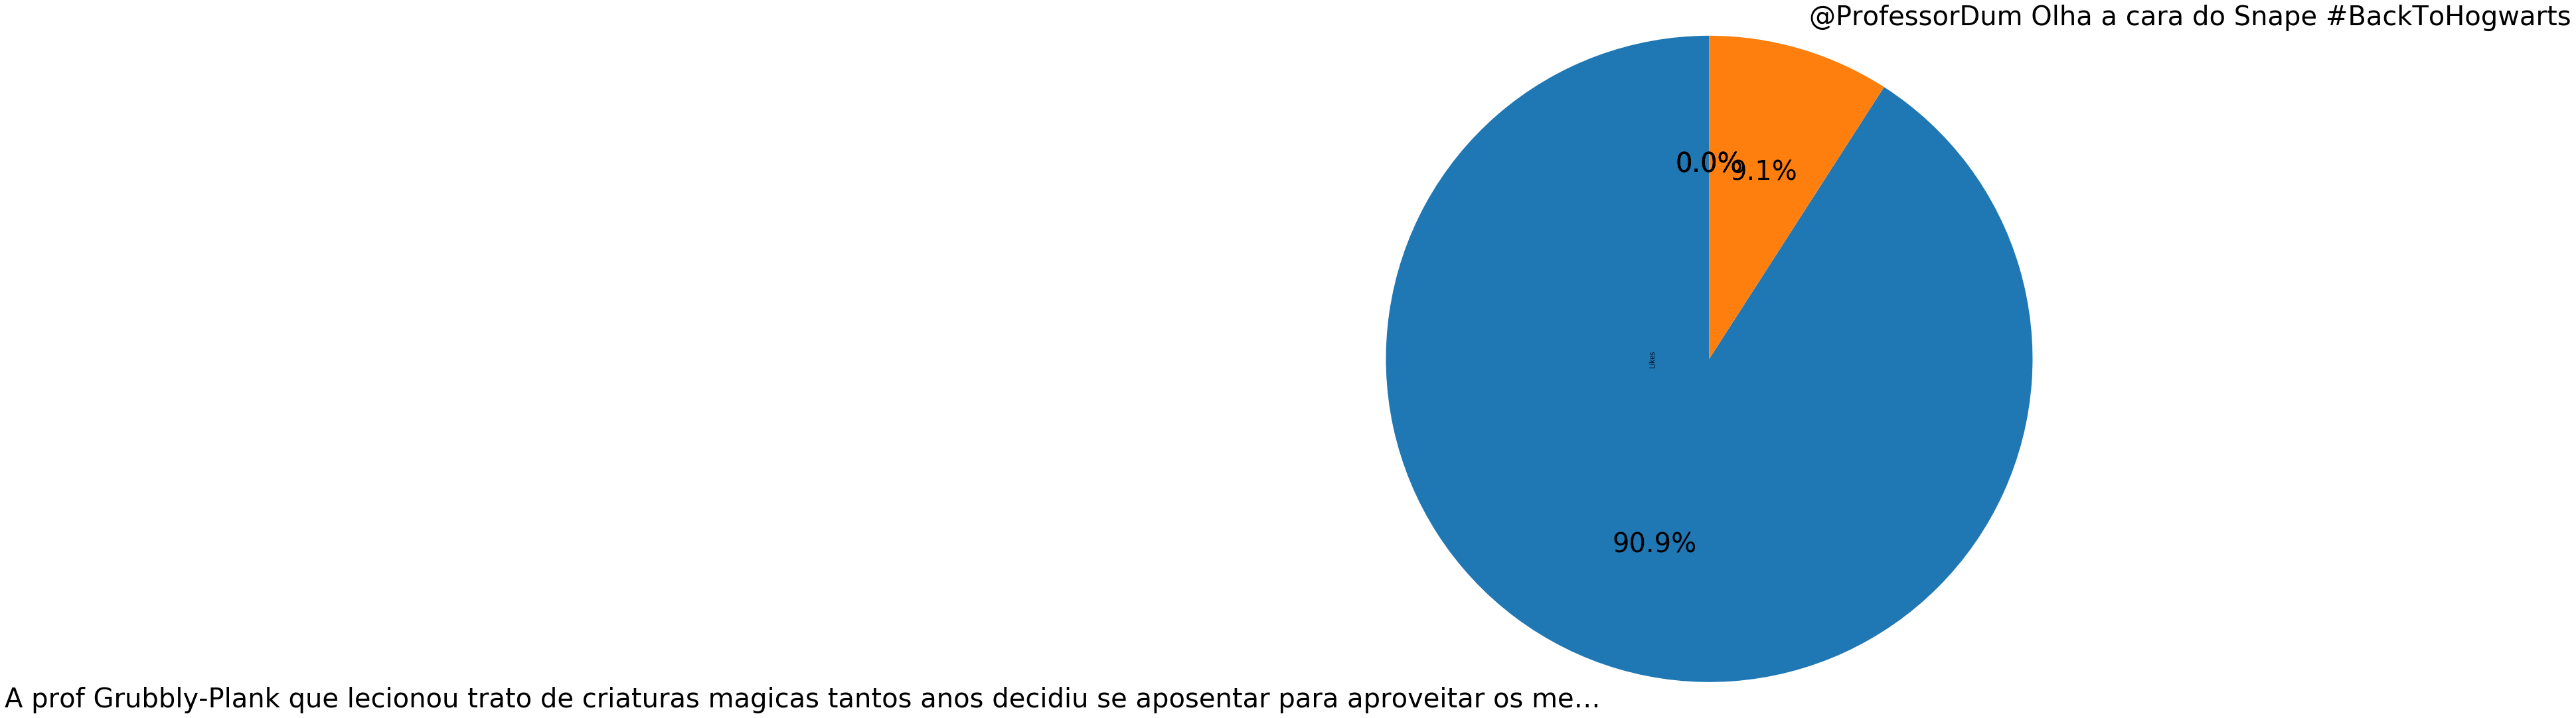

In [166]:
#retrieve top 5 most liked tweets
max_likes = tweet_df.groupBy('Tweet').agg(func.sum("Likes").alias('Likes'))
max_likes = max_likes.sort(desc('Likes')).limit(5)
max_likes.show()
pdf3=max_likes.toPandas()
plt.title("Most Liked Tweets on " + mostPopular,fontsize = 40)
ax1 = plt.subplot(121, aspect='equal')
pdf3.plot(kind='pie', y = 'Likes', ax=ax1, autopct='%1.1f%%', startangle=90, shadow=False, labels=pdf3['Tweet'], legend = False, fontsize= 40, radius=8)



In [167]:
popular_month=(tweet_df.groupBy('Created_At').count())
mon_popular = popular_month.sort(desc('count')).show()

+----------+-----+
|Created_At|count|
+----------+-----+
|2018-09-01|  100|
+----------+-----+



In [168]:
#positive words for sentimental analysis
pos = []
with open(r'C:\Users\Ikshita\Documents\spark-2.3.1-bin-hadoop2.7\bin\positive.txt') as file1:
    for line in file1: 
        line = line.strip().lower() 
        pos.append(line)

#negative words for sentimental analysis
neg = []
with open(r'C:\Users\Ikshita\Documents\spark-2.3.1-bin-hadoop2.7\bin\negative.txt') as file2:
    for line in file2: 
        line = line.strip().lower()
        neg.append(line)


30
34


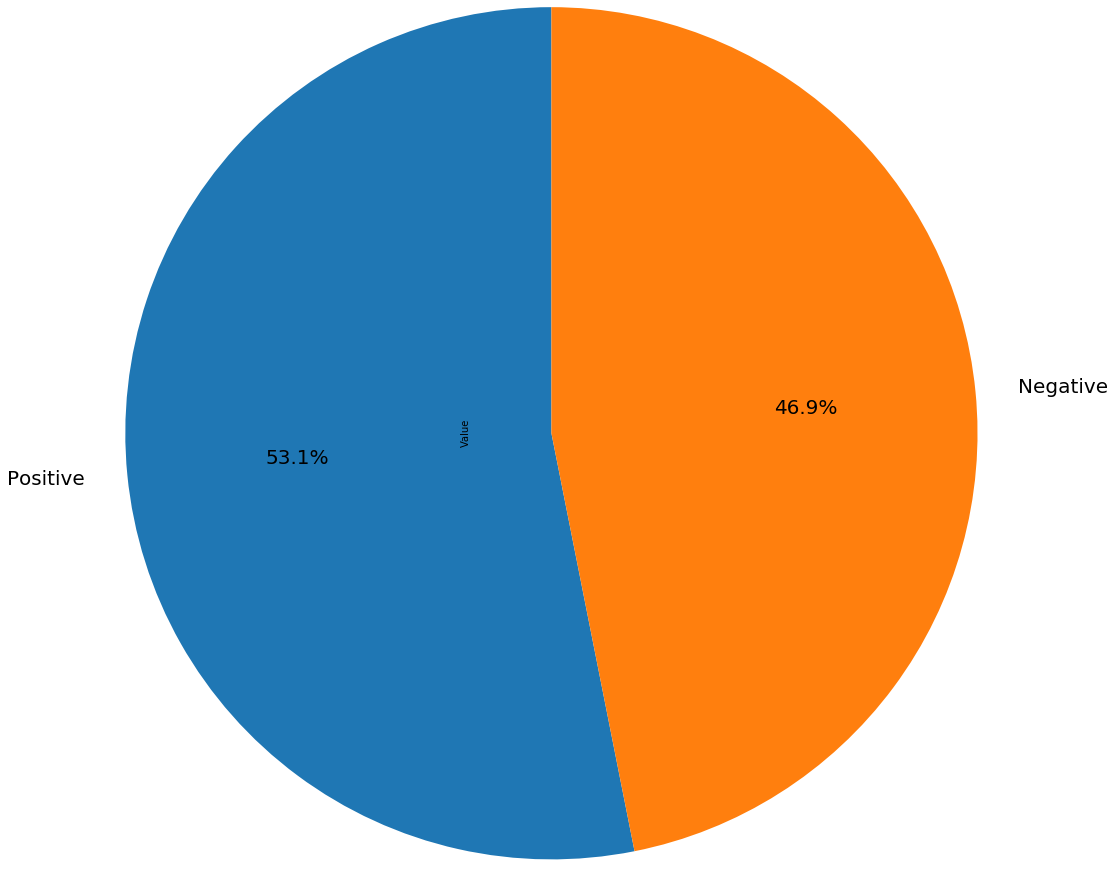

In [169]:
#use RDD for word comparision for sentimental analysis
#find negtive sentiments and positive sentiment percentage about the topic 
newlist = []
for tweet in tweets:
    data = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', tweet.text)
    data =  re.findall(r'\w+', data.lower())
    newlist.append(data)
words = sc.parallelize(newlist)
words.take(100)
words_neg = words.map(lambda x : (x,1) if [i for i in x if i in neg] else (x,0))
words_pos = words.map(lambda x : (x,1) if [i for i in x if i in pos] else (x,0)) 
neg_percent = words_neg.map(lambda x :x[1]).collect()
neg_percent = (sum(neg_percent))
print(neg_percent)
pos_percent = words_pos.map(lambda x :x[1]).collect()
pos_percent = (sum(pos_percent))
print(pos_percent)


#plot sentiment percentage
from pyspark.sql import Row
l = [('Positive',pos_percent),('Negative',neg_percent)]
rdd = sc.parallelize(l)
sentiment = rdd.map(lambda x: Row(Sentiments=x[0], Value=int(x[1])))
sentiment = sqlContext.createDataFrame(sentiment)
pie=sentiment.toPandas()
plt.title(" Sentimental Analysis On " +mostPopular,fontsize = 20)
ax1 = plt.subplot(121, aspect='equal')
pie.plot(kind='pie', y = 'Value', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=pie['Sentiments'], legend = False,fontsize= 20, radius=7)

+--------------------+---------+
|               Tweet|       SA|
+--------------------+---------+
|RT    Un a o m s ...|Negavtive|
|RT    Hogwarts is...| Positive|
|RT    Chegamos em...|Negavtive|
|RT    Chegamos em...|Negavtive|
|RT     Szukam now...|Negavtive|
|RT    Got your ti...|Negavtive|
|RT    It s Septem...|Negavtive|
|RT    Who s ready...| Positive|
|RT    School is b...|Negavtive|
|RT    me  it s se...| Positive|
|RT    Look who st...|Negavtive|
|RT    Dos Autobus...|Negavtive|
|Finalmente em cas...|Negavtive|
|My  CommonRoom to...|Negavtive|
|RT    O elenco de...|Negavtive|
|RT    A fantastic...| Positive|
|RT    Fun fact  M...| Positive|
|RT     Lista para...|Negavtive|
|RT    Skoro ju  t...|Negavtive|
|RT     Algu m viu...|Negavtive|
+--------------------+---------+
only showing top 20 rows

+---------+-----+
|       SA|count|
+---------+-----+
|Negavtive|   63|
| Positive|   31|
|  Neutral|    6|
+---------+-----+



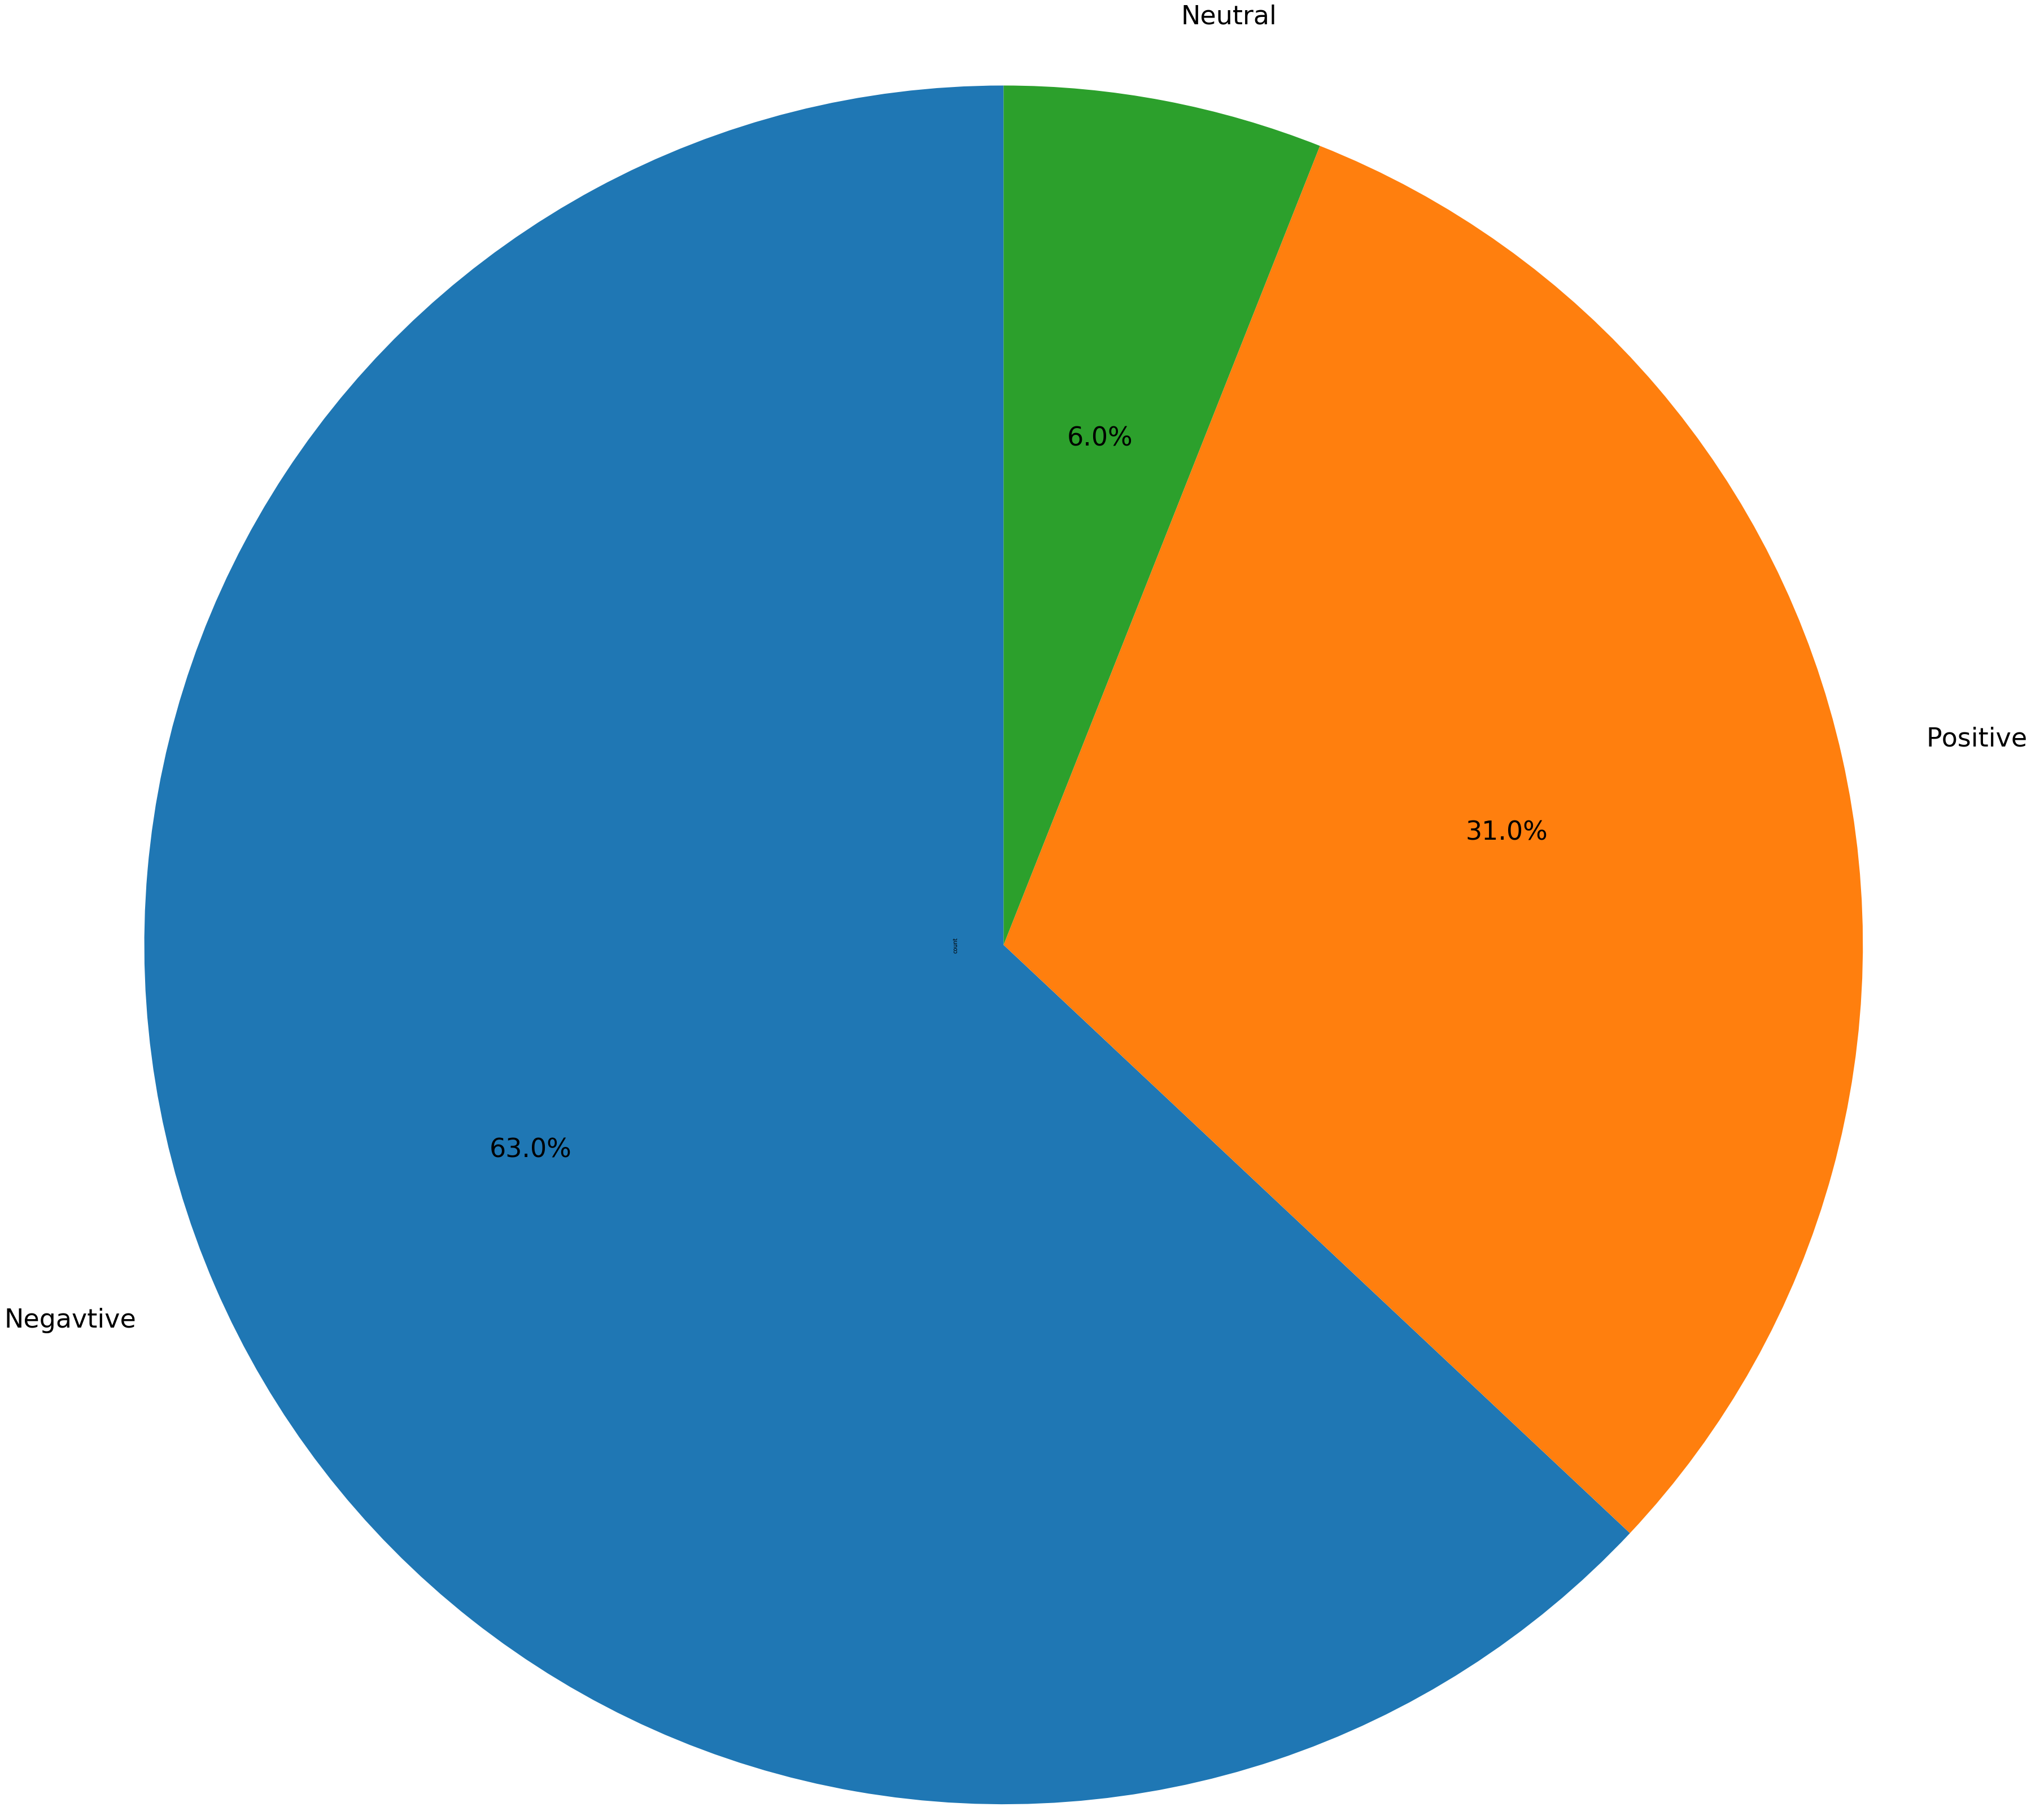

In [170]:
#Sentimental Analysis using Textblob
from textblob import TextBlob
import re
txtblb=[]
for tweet in tweets:
    data = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet.text)
    txtblb.append(data) 
    analysis = TextBlob(data)
    if analysis.sentiment.polarity > 0:
        txtblb.append('Positive') 
    elif analysis.sentiment.polarity == 0:
        txtblb.append('Negavtive')
    else:
        txtblb.append('Neutral')
sent_tweet = [txtblb[2*i:2*i+2] for i in range(0,math.ceil(len(txtblb)/2))]
sent_tweet = spark.createDataFrame(sent_tweet, ["Tweet", "SA"])
sent_tweet = sent_tweet.withColumn("Tweet", sent_tweet["Tweet"].cast(StringType())).withColumn("SA", sent_tweet["SA"].cast(StringType()))
sent_tweet.show()
sent_tweet = (sent_tweet.groupBy('SA').count())
sent_tweet.show()
sent_tweet_pdf=sent_tweet.toPandas()
ax1 = plt.subplot(121, aspect='equal')
sent_tweet_pdf.plot(kind='pie', y = 'count', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=sent_tweet_pdf['SA'], legend = False, fontsize= 46, radius=25)